# Portfolio Analysis.

# 1. Get expert data.

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import pyfolio as pf

%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Get CSV paths.
from os import listdir
from os.path import isfile, join
mypath = "./dataset"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

robot_files = list()
for i in onlyfiles:
    if i[0] == "e":
        robot_files.append(i)

# Robots files.
robot_files

['expert_4321_data.csv', 'expert_4376_data.csv', 'expert_5874_data.csv']

In [3]:
trades = pd.DataFrame()
count = 0
assets = [str(i + 1) for i in range(len(robot_files))]

for f in robot_files:
    
    # Load positions data.
    data = pd.read_csv(mypath + "/" + f)
    data["symbol"] = assets[count]
    
    # Drop columns.
    data.drop("deal", axis = 1, inplace = True)
    data.drop("balance", axis = 1, inplace = True)
    data.drop("comment", axis = 1, inplace = True)
    
    # Set datetime index.
    data.date_time = pd.to_datetime(data.date_time)
    data.columns = "date_time symbol order_type direction volume price take_profit stop_loss order_num commission swap profit".split()
    data.set_index("date_time", inplace = True)
    
    # Generate dataframe.
    if count == 0: trades = data.copy()
    else: trades = pd.concat([trades, data])
    count += 1


# Sort dataframe by index.
trades.sort_index(inplace = True)
trades.fillna(0, inplace = True)

# Generate balance column.
balance_arr = list()
profits_arr = trades.profit.values
balance = 5000

for i in profits_arr:
    balance = balance + i
    balance_arr.append(balance)
balance_series = pd.DataFrame(data = balance_arr, index = trades.index, columns=["balance"])  

# Append balance series to trades dataframe.
trades = trades.join(balance_series)

# Save dataframe.
trades.to_csv("./dataset/portfolio_data.csv")

# Show dataframe.
trades.head()

,symbol,order_type,direction,volume,price,take_profit,stop_loss,order_num,commission,swap,profit,balance
date_time,,,,,,,,,,,,
2018-01-02 00:00:00,1,sell,in,0.01,1.20088,0.00000,0.0,2,0.0,0.0,0.00,5000.00
2018-01-03 04:00:00,2,sell,in,0.08,1.20529,0.00000,0.0,2,0.0,0.0,0.00,5000.00
2018-01-03 08:00:00,2,buy,out,0.08,1.20583,0.00000,0.0,3,0.0,0.0,-4.32,4995.68
2018-01-03 09:00:00,2,sell,in,0.08,1.20448,0.00000,0.0,4,0.0,0.0,0.00,4995.68
2018-01-08 03:09:40,3,buy,in,0.10,1.20468,1.20967,0.0,2,0.0,0.0,0.00,4995.68


# Generate portfolio balance.

In [4]:
# Adding days functions.
def addDay(data, money, date, column_name, insert = True):
    ini_date = pd.DataFrame(data = [[money, date]], columns = [column_name, "index"])
    ini_date.index = pd.to_datetime(ini_date.index)
    ini_date.set_index("index", inplace = True)

    
    if insert: 
        return  pd.concat([ini_date, data]).copy()
    else:
        return  pd.concat([data, ini_date]).copy()

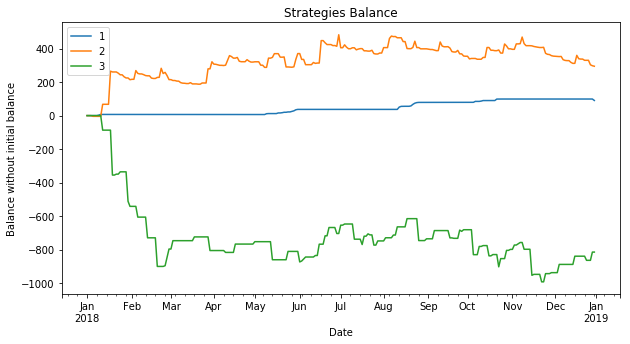

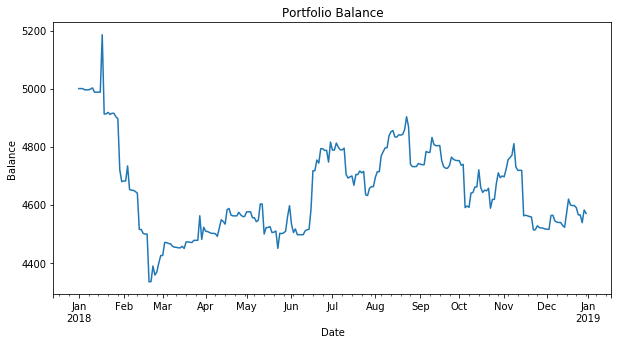

In [5]:
# Generate portfolio dataframe.
portfolio = pd.DataFrame()
count = 0
assets = [str(i + 1) for i in range(len(robot_files))]
initial_balance = 5000

for f in robot_files:
    
    # load info.
    data = pd.read_csv(mypath + "/" + f)
    data = data[data.direction == "out"][["date_time", "balance"]]
    data.date_time = pd.to_datetime(data.date_time)
    data.columns = ["index", assets[count]]
    data.set_index("index", inplace = True)
    
    # Substract initial balance.
    data[assets[count]] = data[assets[count]] - initial_balance

    # Add beggining and end of the year.
    data = addDay(data, 0, "2018-01-01 00:00:00", assets[count], True)
    data = addDay(data, data.iloc[-1].values[0], "2018-12-31 00:00:00", assets[count], False)
    data.index = pd.to_datetime(data.index)

    # Resample data.
    data = data.resample("B").pad().fillna(0) #.pct_change(fill_method = "pad").fillna(0) #.tz_localize('UTC')

    if count == 0: portfolio = data.copy()
    else: portfolio = portfolio.join(data)
    count += 1

# Fill NaN values.
portfolio.fillna(0, inplace = True)

# Generate portfolio balance.
portfolio["balance"] = (portfolio["1"] + portfolio["2"] + portfolio["3"]) + 5000

# Plot strategies balance.
portfolio[assets].plot(figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Balance without initial balance")
plt.title("Strategies Balance")
plt.savefig("./figures/strategies_balance.png")
plt.show()

# Plot portfolio balance.
portfolio["balance"].plot(figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Balance")
plt.title("Portfolio Balance")
plt.savefig("./figures/balance.png")
plt.show()

# Get portfolio returns.

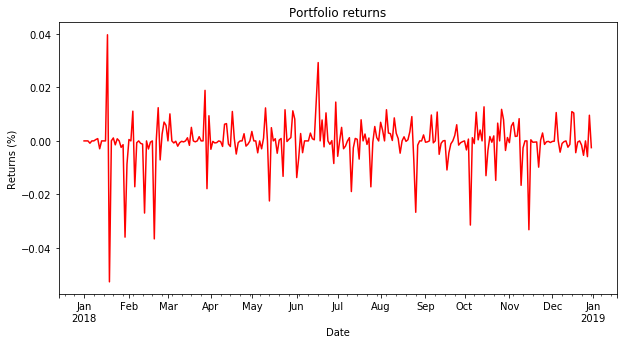

In [6]:
portfolio2 = portfolio["balance"].copy()
returns = portfolio2.resample("B").pad().pct_change(fill_method="pad").fillna(0)
returns = returns.tz_localize("UTC")

returns.plot(figsize=(10,5), c = "red")
plt.title("Portfolio returns")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.savefig("./figures/returns.png")
plt.show()

# Get portfolio transactions.

                           amount    price symbol
index                                            
2018-01-02 00:00:00+00:00   -0.01  1.20088      1
2018-01-03 04:00:00+00:00   -0.08  1.20529      2
2018-01-03 09:00:00+00:00   -0.08  1.20448      2
2018-01-08 03:09:40+00:00    0.10  1.20468      3
2018-01-08 05:00:00+00:00   -0.08  1.20358      2


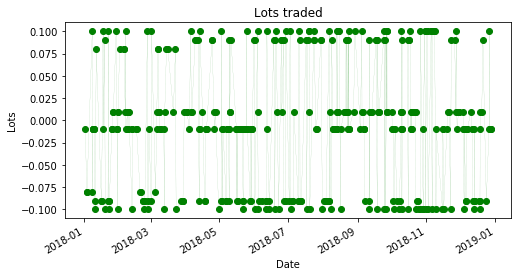

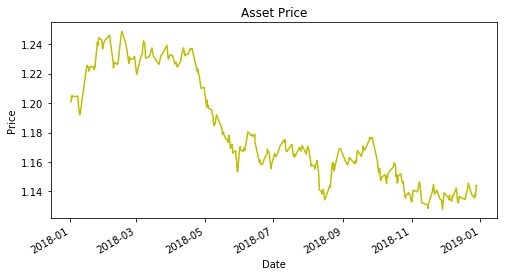

In [7]:
# Get transactions of all experts.

"""
- Example:
            index                  amount   price    symbol
            2004-01-09 12:18:01    483      324.12   'AAPL'
            2004-01-09 12:18:01    122      83.10    'MSFT'
            2004-01-13 14:12:23    -75      340.43   'AAPL'
"""

transactions = pd.DataFrame()
count = 0
assets = [str(i + 1) for i in range(len(robot_files))]

for f in robot_files:
    
    # Load transactions data.
    data = pd.read_csv(mypath + "/" + f)
    data = data[data.direction == "in"][["date_time", "volume", "price","symbol", "order_type"]]
    data.symbol = assets[count] 
    
    # Get volume sign.
    data["sign"] = np.where(data.order_type == "sell", -1, 1)
    data.volume = data.volume * data.sign
    
    # Drop columns.
    data.drop("sign", axis = 1, inplace = True)
    data.drop("order_type", axis = 1, inplace = True)
    
    # Set index.
    data.date_time = pd.to_datetime(data.date_time)   
    data.columns = ["index", "amount", "price", "symbol"]
    data.set_index("index", inplace = True)
    
    # Set datetime like object.
    data = data.tz_localize("UTC")
    
    # Append to transactions log.
    transactions = transactions.append(data)
    count += 1
    
# Sort transactions by index.
transactions.sort_index(inplace = True)
    
# Show df.
print(transactions.head())
    
# Plot lots traded.
transactions["amount"].plot(figsize=(8,4), c="g", marker = "o", linestyle="dashed", linewidth=0.1)
plt.title("Lots traded")
plt.xlabel("Date")
plt.ylabel("Lots")
plt.savefig("./figures/lots_traded.png")
plt.show()

# Plot asset price.
transactions["price"].plot(figsize=(8,4), c = "y")
plt.title("Asset Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.savefig("./figures/asset_price.png")
plt.show()

# Get portfolio positions.

                                 1         2        3       cash
index                                                           
2018-01-02 00:00:00+00:00 -12.0088    0.0000    0.000  4987.9912
2018-01-03 00:00:00+00:00   0.0000 -192.7816    0.000  4807.2184
2018-01-04 00:00:00+00:00   0.0000    0.0000    0.000  4995.6800
2018-01-05 00:00:00+00:00   0.0000    0.0000    0.000  4995.6800
2018-01-08 00:00:00+00:00 -35.9536  -96.2864  120.468  4742.9720



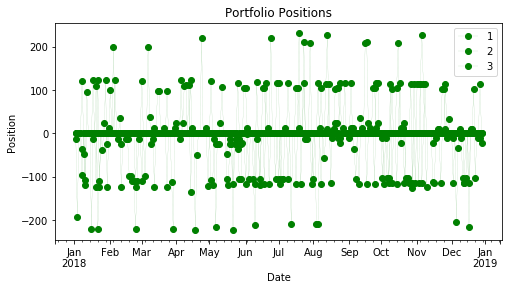

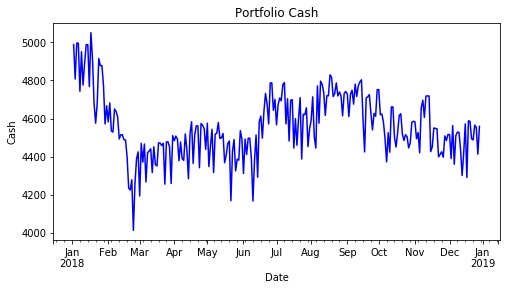

In [8]:
# Get positions of all experts.

"""
- Example:
            index         'AAPL'         'MSFT'          cash
            2004-01-09    13939.3800     -14012.9930     711.5585
            2004-01-12    14492.6300     -14624.8700     27.1821
            2004-01-13    -13853.2800    13653.6400      -43.6375
"""
positions = pd.DataFrame()
count = 0
assets = [str(i + 1) for i in range(len(robot_files))]

for f in robot_files:
    
    # Load positions data.
    data = pd.read_csv(mypath + "/" + f)
    data = data[["date_time", "volume", "price","symbol", "order_type", "direction"]]
    data["symbol"] = assets[count]
    
    # Get volume sign.
    data["sign"] = np.where(data.order_type == "sell", -1, 1)
    data["abs_pos"] = data.volume * data.price * 1000
    data.volume = data.volume * data.sign
    
    # Get position value.
    data["position"] = data.volume * data.price * 1000
    data["position"][data.direction == "out"] = 0
    data["abs_pos"][data.direction == "out"] = 0
    
    # Drop columns.
    data.drop("direction", axis = 1, inplace = True)
    data.drop("order_type", axis = 1, inplace = True)
    data.drop("sign", axis = 1, inplace = True)
    data.drop("price", axis = 1, inplace = True)
    data.drop("volume", axis = 1, inplace = True)
    
    # Set Date as index.
    data.date_time = pd.to_datetime(data.date_time)   
    data.columns = ["index", "symbol", "abs_pos", assets[count]]
    data.set_index("index", inplace = True)

    # Drop last columns.
    data.drop("abs_pos", axis=1, inplace=True)
    data.drop("symbol", axis=1, inplace=True)
    
    # Set datetime like object.
    data = data.tz_localize("UTC")
    
    # Resample data.
    data = data.resample("B").sum().fillna(0) #.pad().dropna().tz_localize('UTC')
    
    
    # Add to positions dataframe.
    if count == 0: positions = data.copy()
    else: positions = positions.join(data)

    # Count++
    count += 1
    
# Fill NaN values.
positions.fillna(0, inplace = True)

# Load portfolio balance.
balance = portfolio2.copy()
balance = balance.tz_localize("UTC")
positions = positions.join(balance)

# Get cash values
cash = []
for indice_fila, fila in positions.iterrows():
    value = abs(fila[0]) + abs(fila[1]) + abs(fila[2])
    cash.append(value)
cash_series = pd.DataFrame(data=cash, index = positions.index, columns=["cash"])
positions = positions.join(cash_series)

# Set cash column.
positions["cash"] = positions.balance - positions.cash

# Drop balance column.
positions.drop("balance", axis = 1, inplace=True)

# Print positions.
print(positions.head())
print("")

# Plot positions.
positions[assets].plot(figsize=(8,4), c="g", marker = "o", linestyle="dashed", linewidth=0.1)
plt.title("Portfolio Positions")
plt.xlabel("Date")
plt.ylabel("Position")
plt.savefig("./figures/positions.png")
plt.show()

# Plot cash.
positions["cash"].plot(figsize=(8,4), c="b")
plt.title("Portfolio Cash")
plt.xlabel("Date")
plt.ylabel("Cash")
plt.savefig("./figures/cash.png")
plt.show()


# Getting S&P500 Benchmark. 

In [9]:
# Import libraries.
from pandas_datareader import data as web

Business Days:  261


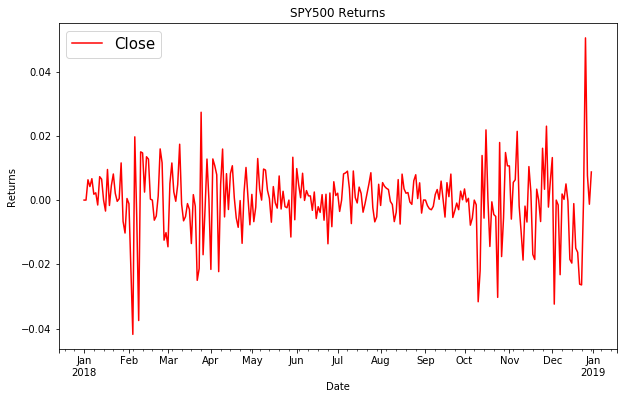

In [10]:
# Getting S&P500 Data.
start = datetime.datetime(2018, 1, 1, 0, 0, 0)
end = datetime.datetime(2018, 12, 31, 0, 0, 0)
spy500 = web.get_data_yahoo('SPY',start=start,end=end)
spy500 = spy500["Close"].to_frame().copy()
spy500 = addDay(spy500, spy500.iloc[0].values[0], "2018-01-01 00:00:00", "Close", True)
spy500.index = pd.to_datetime(spy500.index)

spy500 = spy500.resample("B").pad().pct_change(fill_method = "pad").fillna(0) 
print("Business Days: ", spy500["Close"].count())

# Set datetime like object.
spy500 = spy500.tz_localize("UTC")

# Plot benchmark returns.
spy500.plot(figsize=(10,6), c = "red")
plt.title("SPY500 Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend(prop = {"size": 15})
plt.show()

# 2. Initial Analysis.

# 2.1 Montecarlo Analysis.

In [11]:
# Calculate montecarlo variables
profit_vol = trades[trades.profit > 0]["profit"].std()
loss_vol = trades[trades.profit < 0]["profit"].std()

good_trades = trades[(trades.profit > 0) & (trades.direction == "out")]["profit"].count()
total_trades = trades[(trades.direction == "out")]["profit"].count()

ratio_wl = (good_trades / total_trades)

In [12]:
# Monte Carlo Simulation.
def montecarlo_simulation(last_balance, p_vol, l_vol, n_simulations = 100, n_days = 252):
    
    # Set monte carlo variables.
    last_balance = last_balance #.iloc[-1]
    num_simulations = n_simulations
    num_days = n_days
    
    # Create dataframe simulation.
    simulation_df = pd.DataFrame()
    

    for x in range(num_simulations):
        count = 0        
        price_series = []
    
        random_num = np.random.uniform(1, 10) / 10
        if random_num > ratio_wl:
            price = last_balance + abs((1 + np.random.normal(0, l_vol))) * -1
        else:
            price = last_balance + abs((1 + np.random.normal(0, p_vol)))
        price_series.append(price)
        
        for y in range(num_days - 1):
            if count == n_days:
                break
                
            random_num = np.random.uniform(1, 10) / 10
            if random_num >= ratio_wl:
                price = price_series[count] + abs((1 + np.random.normal(0, l_vol))) * -1
            else:
                price = price_series[count] + abs((1 + np.random.normal(0, p_vol)))
            
            #price = price_series[count] + (1 + np.random.normal(0, profit_vol))
            
            price_series.append(price)
            count += 1
            
        simulation_df[x] = price_series
    return simulation_df

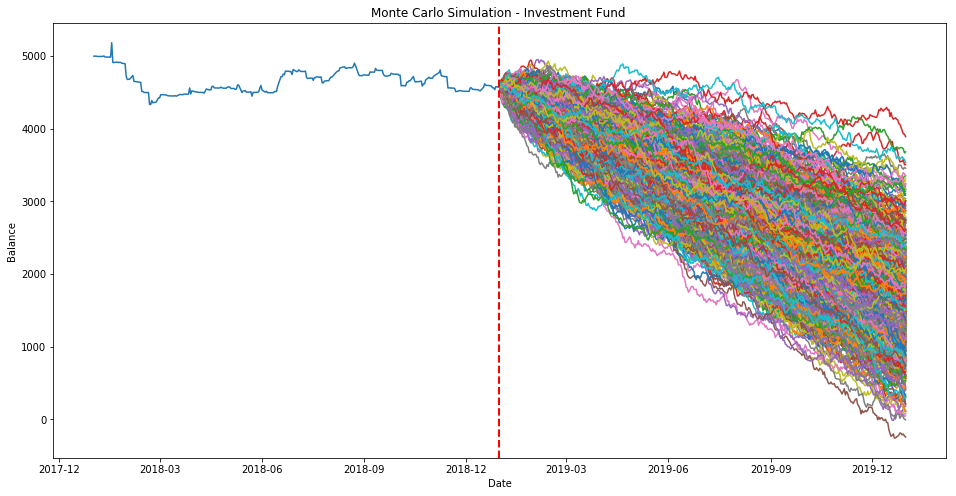

Number of positive outcomes:  0 0.0 %
Number of negative outcomes:  1000 100.0 %
Number of Days simulated:  626
Initial Balance:  4570.09
Mean Balance:  1679.95
Net Mean Profit:  -2890.14
Montecarlo Profiability:  -63.24 %


In [13]:
# Simulations days.
days = 365

# Process montecarlo data.
monte_data = (portfolio["balance"].to_frame()).copy()

# Get results dataframe simulation.
last_balance = monte_data.iloc[-1].values[0]
last_day = monte_data.index[monte_data["balance"] == last_balance][-1]

# Get results of simulation.
results = montecarlo_simulation(last_balance, profit_vol, loss_vol, n_simulations = 1000, n_days = days)

# Generate 253 days.
date_list = [last_day + datetime.timedelta(days=x) for x in range(0, days + 1)][1:]

# Set indexes names.
results.index = date_list

# Concat balance with montecarlo results.
results = pd.concat([balance, results])

# Plot results.
fig = plt.figure()
plt.figure(figsize=(16,8))
plt.title("Monte Carlo Simulation - Investment Fund ")
plt.plot(results)
#plt.axhline(y = last_balance, color = "b", linestyle = "-", lw=3)
plt.axvline(x=last_day, color = "r", linestyle = "--", lw=2)
plt.xlabel("Date")
plt.ylabel("Balance")
plt.savefig("./figures/montecarlo.png")
plt.show()

good = 0
for i in (results.iloc[-1].values > last_balance):
    if i == True:
        good += 1
    
# Define variables.
positive_outcomes_abs = good 
negative_outcomes_abs = 1000 - positive_outcomes_abs
positive_outcomes_rel = round((good / (1000 - good)) * 100, 2)
negative_outcomes_rel = round( (1 - (good / (1000 - good))) * 100, 2)
montecarlo_days_simulated = results[0].count()
montecarlo_mean_balance = round(results.iloc[-1].mean(), 2)
montecarlo_mean_netprofit = round(results.iloc[-1].mean() - last_balance, 2)
montecarlo_profiability = round(montecarlo_mean_netprofit / last_balance * 100, 2)
        
print("Number of positive outcomes: ", positive_outcomes_abs, positive_outcomes_rel, "%")
print("Number of negative outcomes: ", negative_outcomes_abs, negative_outcomes_rel, "%")
print("Number of Days simulated: ", montecarlo_days_simulated)
print("Initial Balance: ", last_balance)
print("Mean Balance: ", montecarlo_mean_balance)
print("Net Mean Profit: ", montecarlo_mean_netprofit)
print("Montecarlo Profiability: ", montecarlo_profiability, "%")

# 2.2 Markowitz Optimization.

In [15]:
# Get experts balances.
portfolio_balances = portfolio.copy()
portfolio_balances.drop("balance", axis=1, inplace=True)
portfolio_balances[assets] += 5000

In [16]:
# Mean Daily Return.
mean_daily_returns = portfolio_balances.pct_change(1).mean()
mean_daily_returns

1    0.000069
2    0.000230
3   -0.000651
dtype: float64

          1         2         3
1  1.000000  0.003249  0.000220
2  0.003249  1.000000  0.005918
3  0.000220  0.005918  1.000000


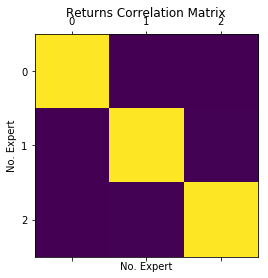

In [85]:
# Returns correlation matrix.
corrs = portfolio_balances.pct_change(1).corr() ** 2
print(corrs)

plt.matshow(corrs)
plt.title("Returns Correlation Matrix")
plt.tight_layout()
plt.xlabel("No. Expert")
plt.ylabel("No. Expert")
plt.savefig("./figures/returns_correlation_matrix.png")
plt.show()

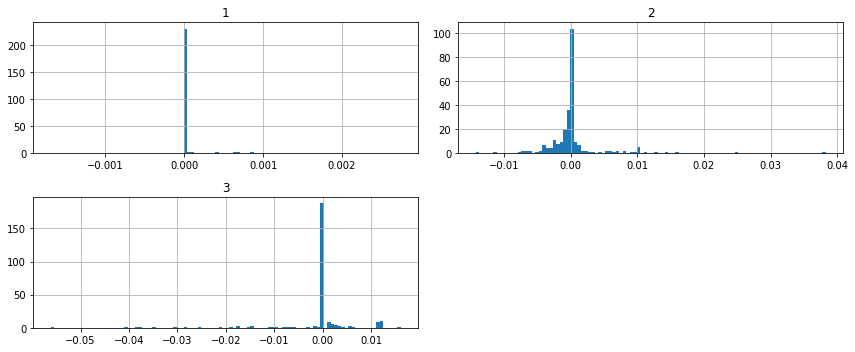

In [18]:
# Get logarithmic returns.
log_ret = np.log(portfolio_balances / portfolio_balances.shift(1))
log_ret.hist(bins = 100, figsize = (12,5))
plt.tight_layout()
plt.axis("off")
plt.show()

In [19]:
# Describe logarithmic returns.
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1,260.0,0.000069,0.000319,-0.001694,0.000000,0.0,0.0,0.002744
2,260.0,0.000220,0.004402,-0.014251,-0.000867,0.0,0.0,0.038281
3,260.0,-0.000684,0.008174,-0.056156,0.000000,0.0,0.0,0.016107


In [20]:
# Expected annual return in percentage.
log_ret.mean() * 252 * 100

1     1.736335
2     5.553742
3   -17.249346
dtype: float64

In [114]:
# Mathematical Optimization
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

In [115]:
# Import minimize.
from scipy.optimize import minimize

In [116]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [117]:
# Contraints.
def check_sum(weights):
    return np.sum(weights) - 1

In [118]:
# By convention of minimize function it should be a function that returns zero for conditions.
cons = ({"type": "eq", "fun": check_sum})

In [147]:
# 0-1 bounds for each weight.
bounds = list()
for f in robot_files:
    bounds.append((0, 1))
bounds = tuple(bounds)
bounds

((0, 1), (0, 1), (0, 1))

In [146]:
# Initial GUess (equal distribution.)
init_guess = list()
for f in robot_files:
    init_guess.append(0.25)
init_guess

[0.25, 0.25, 0.25]

In [121]:
# Sequential Least Squares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [123]:
# All Optiminal Portfolios (Efficient Frontier).
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on.
frontier_y = np.linspace(0, 0.3, 100)

In [125]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [126]:
frontier_volatility = []
for possible_return in frontier_y:
    # function for return.
    cons = ({"type": "eq", "fun": check_sum}, 
            {"type": "eq", "fun": lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, init_guess, method = "SLSQP", bounds = bounds, constraints = cons)
    frontier_volatility.append(result["fun"])

In [195]:
robot_names = robot_files.copy()
for rn in range(len(robot_names)):
    robot_names[rn] = (robot_names[rn].replace("_data.csv", "")).capitalize()
print(robot_names)

['Expert_4321', 'Expert_4376', 'Expert_5874']


In [218]:
for w in range(len(opt_results.x)):
    opt_results.x[w] = round(opt_results.x[w], 3)

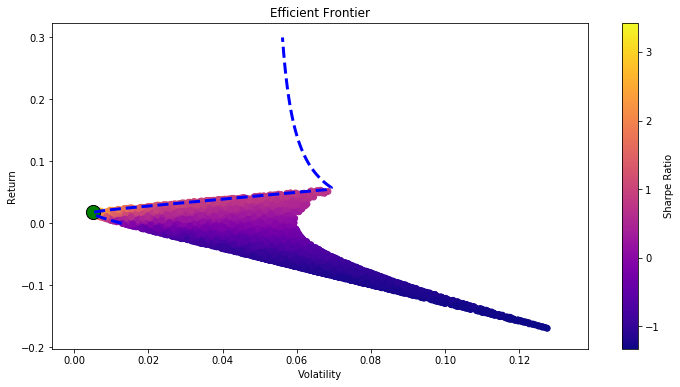

Optimal Portfolio Sharpe Ratio:  3.43

Allocation results: 
Expert_4321 => 4510.68 ( 98.7 % )
Expert_4376 => 59.41 ( 1.3 % )
Expert_5874 => 0.0 ( 0.0 % )

Expert Expert_4321
Investment in dlls:  4510.6788
Risk 2% in dlls:  90.21357599999999
Lot Size per Trade  0.4510678799999999

Expert Expert_4376
Investment in dlls:  59.4112
Risk 2% in dlls:  1.188224
Lot Size per Trade  0.0039607466666666665

Expert Expert_5874
Investment in dlls:  0.0
Risk 2% in dlls:  0.0
Lot Size per Trade  0.0


In [219]:
plt.figure(figsize=(12,6))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = "plasma")
plt.colorbar(label = "Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")

# Add red dot for max SR.
plt.scatter(max_sr_vol, max_sr_ret, c= "green", s = 200, edgecolors="black")

# Add frontier line.
plt.plot(frontier_volatility, frontier_y, "b--", linewidth=3)
plt.title("Efficient Frontier")
plt.savefig("./figures/efficient_frontier.png")
plt.show()

# Print results.
optimal_sharpe_ratio = round(max_sr_ret / max_sr_vol, 2)
print("Optimal Portfolio Sharpe Ratio: ", optimal_sharpe_ratio)
money = last_balance
stop_loss_pips = [20, 30, 10]
count = 0

print("")
print("Allocation results: ")
for w in range(len(opt_results.x)):
    print(robot_names[w], "=>", round(opt_results.x[w] * money, 2), "(", round(opt_results.x[w] * 100, 2), "% )")

for w in opt_results.x:
    print("")
    print("Expert " + robot_names[count])
    
    investment = round(w * money, 4)
    print("Investment in dlls: ", investment)
    
    risk = investment * 0.02
    print("Risk 2% in dlls: ", risk)
    
    lots = risk / (stop_loss_pips[count] * 10)
    print("Lot Size per Trade ", lots)
    
    count += 1

# 3. Pyfolio Analysis.

# 3.1 Portfolio Stats.

In [24]:
# Setting variables.
returns = returns
trans = transactions.copy()
benchmark_rets = spy500["Close"].copy()
live_start_date = "2018-11-01"
cone_std = 2

In [25]:
# Show performance stats.
pf.show_perf_stats(returns, benchmark_rets, positions = positions, transactions = trans)

Start date,2018-01-01
End date,2018-12-31
Total months,12
,Backtest
Annual return,-8.3%
Cumulative returns,-8.6%
Annual volatility,13.7%
Sharpe ratio,-0.56
Calmar ratio,-0.51
Stability,0.00
Max drawdown,-16.4%


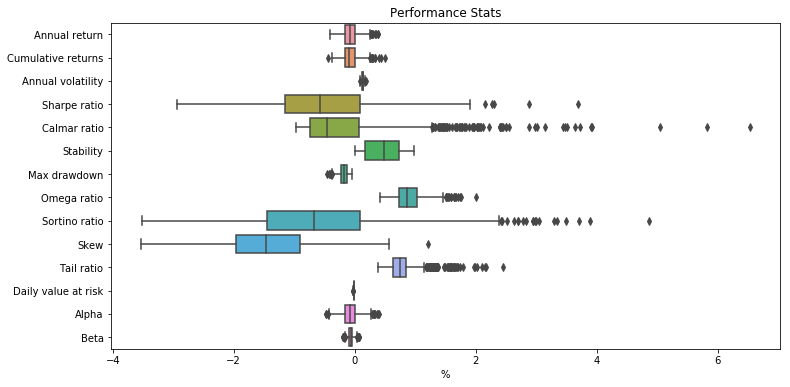

In [26]:
# Plot performance stats.
pf.plot_perf_stats(returns, benchmark_rets)
plt.title("Performance Stats")
plt.xlabel("%")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/perfomance_stats_quantiles.png")
plt.show()

# 3.2 Returns analysis.

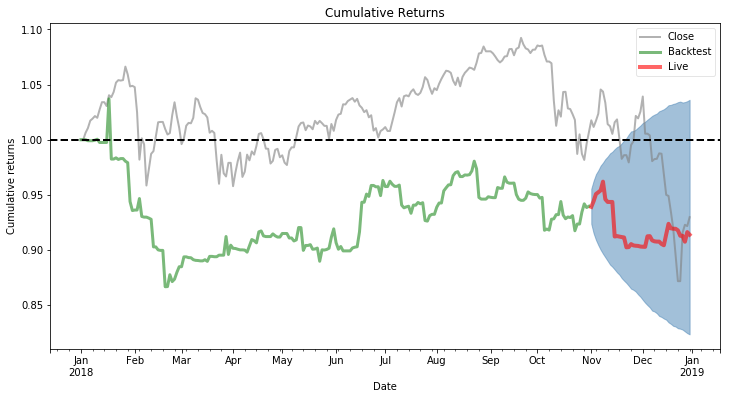

In [27]:
# Plot cumulative returns.
pf.plot_rolling_returns(
    returns, 
    factor_returns = benchmark_rets, 
    live_start_date = live_start_date, 
    cone_std = cone_std)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/cumulative_returns.png")
plt.show()

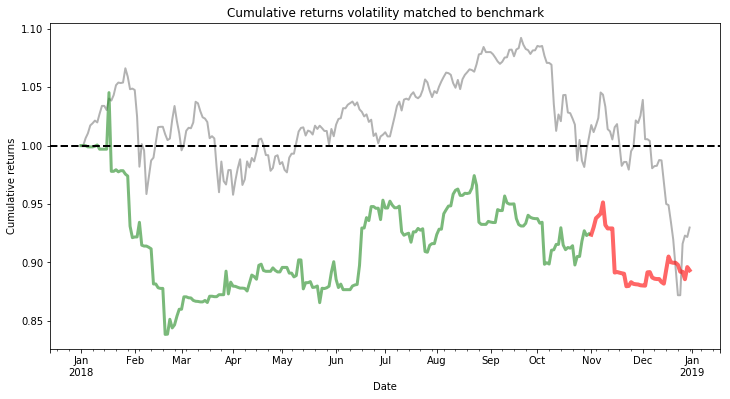

In [28]:
# Plot Cumulative returns volatility matched to benchmark.
pf.plot_rolling_returns(
    returns, 
    factor_returns = benchmark_rets, 
    cone_std = None, 
    live_start_date = live_start_date,
    volatility_match = (benchmark_rets is not None), 
    legend_loc = None
)
plt.title("Cumulative returns volatility matched to benchmark")
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/cumulative_returns_benchmark.png")
plt.show()

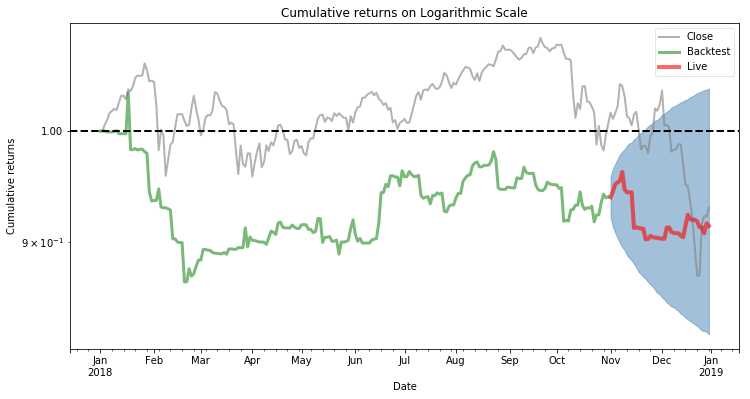

In [29]:
# Plot Cumulative returns on Logarithmic Scale.
pf.plot_rolling_returns(
        returns,
        factor_returns = benchmark_rets,
        logy=True,
        live_start_date = live_start_date,
        cone_std = cone_std
)
plt.title("Cumulative returns on Logarithmic Scale")
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/cumulative_returns_log_scale.png")
plt.show()

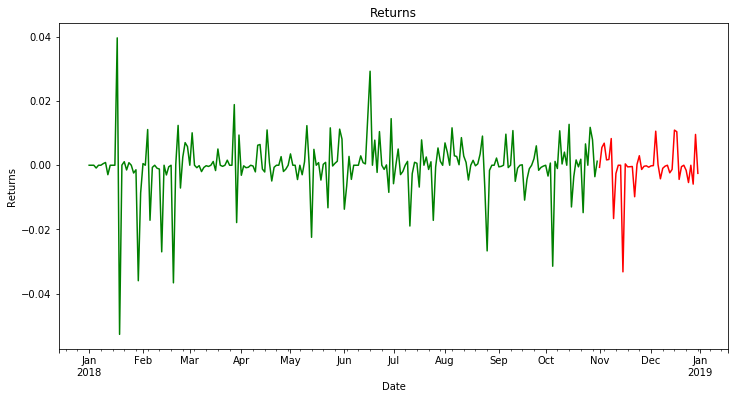

In [30]:
# Plot returns.
pf.plot_returns(returns, live_start_date = live_start_date)
plt.title("Returns")
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/returns_live.png")
plt.show()

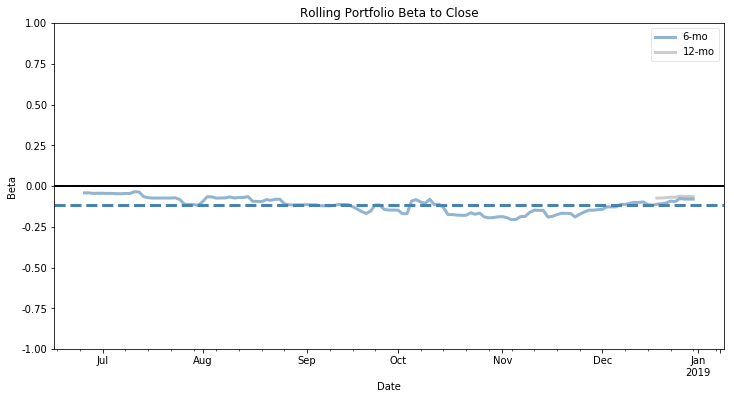

In [31]:
# Plot rolling beta.
pf.plot_rolling_beta(
        returns, 
        benchmark_rets
    )
plt.title("Rolling Portfolio Beta to Close")
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/porfolio_beta_to_close.png")
plt.show()

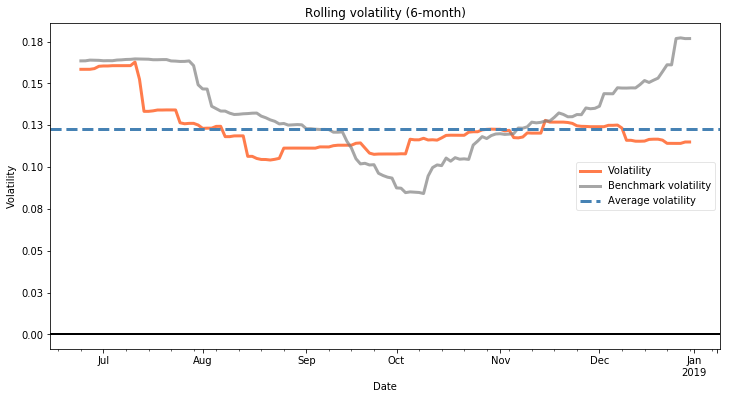

In [32]:
# Plot Rolling volatility (6-month).
pf.plot_rolling_volatility(
        returns, 
        factor_returns=benchmark_rets
)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/rolling_volatility.png")
plt.show()

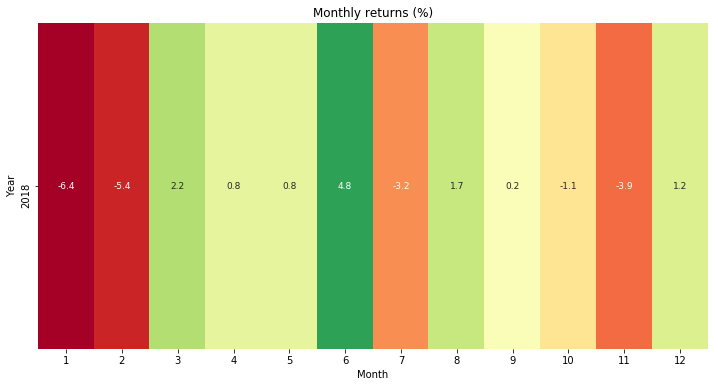

In [33]:
# Plot monthly returns.
pf.plot_monthly_returns_heatmap(returns)
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/monthly_returns.png")
plt.show()

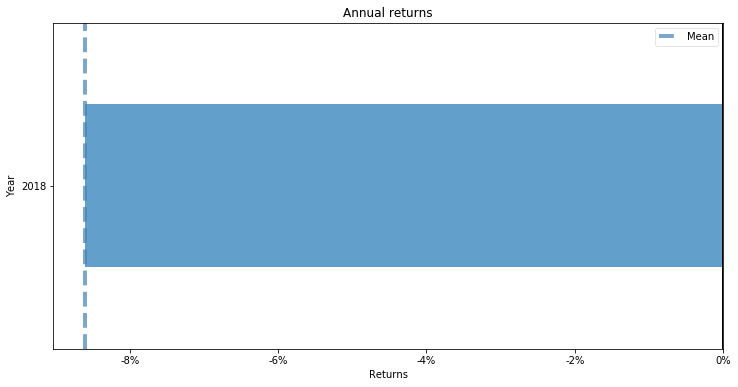

In [35]:
# Plot annual returns.
pf.plot_annual_returns(returns)
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/annual_returns.png")
plt.show()

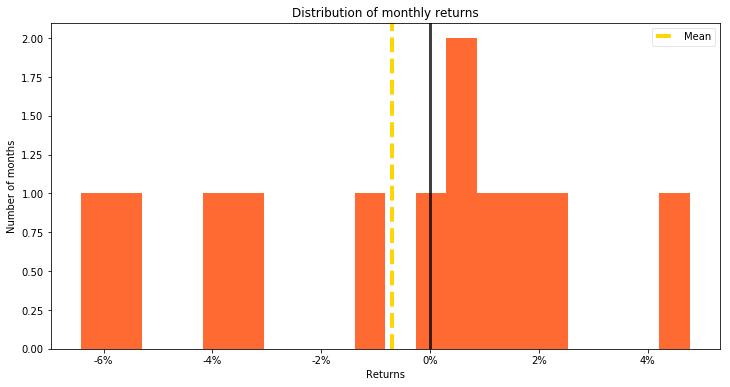

In [36]:
# Plot distribution of monthly returns.
pf.plot_monthly_returns_dist(returns)
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/distribution_monthly_returns.png")

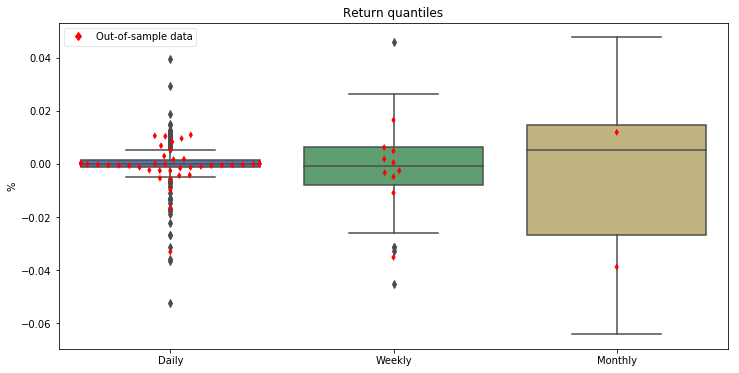

In [37]:
# Plot return quantiles.
pf.plot_return_quantiles(returns, live_start_date = live_start_date)
plt.ylabel("%")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/return_quantiles.png")
plt.show()

# 3.3 Drawdown periods analysis.

In [38]:
# Show worst drawdown periods.
pf.show_worst_drawdown_periods(returns)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.42,2018-01-17,2018-02-20,NaT,NaN
1,0.29,2018-01-10,2018-01-11,2018-01-17,6
2,0.09,2018-01-03,2018-01-04,2018-01-10,6
3,0.00,2018-01-01,2018-01-01,2018-01-01,1
4,0.00,2018-01-01,2018-01-01,2018-01-01,1


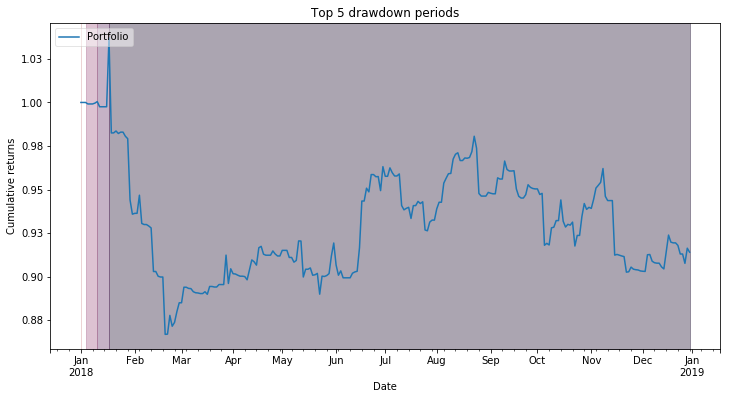

In [39]:
# Plot drawdown periods.
pf.plot_drawdown_periods(returns, top = 5)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/top_5_drawdowns.png")
plt.show()

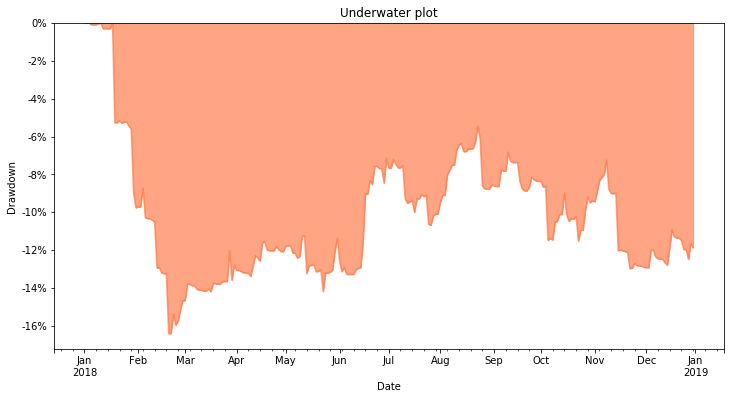

In [40]:
# Plot Drawdown Underwater.
pf.plot_drawdown_underwater(returns)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/underwater_plot.png")
plt.show()

In [41]:
# Calculate recovery factor.
#recovery_factor = round((0.0343 * 5000) / balance.iloc[-1].values[0], 4)
#print("Recovery factor: ", round(recovery_factor * 100, 2))

# 2.5 Interesting Times.

Stress Events,mean,min,max
New Normal,-0.03%,-5.26%,3.96%


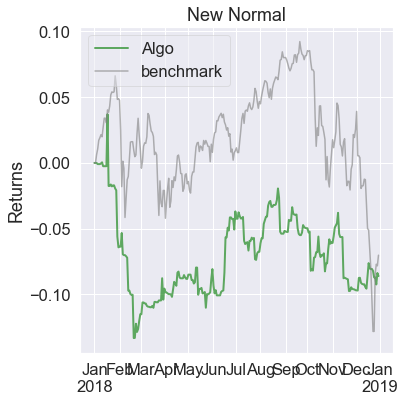

In [42]:
# Generate interesting times.

"""
    Generate a number of returns plots around interesting points in time,
    like the flash crash and 9/11.
    Plots: returns around the dotcom bubble burst, Lehmann Brothers' failure,
    9/11, US downgrade and EU debt crisis, Fukushima meltdown, US housing
    bubble burst, EZB IR, Great Recession (August 2007, March and September
    of 2008, Q1 & Q2 2009), flash crash, April and October 2014.
    benchmark_rets must be passed, as it is meaningless to analyze performance
    during interesting times without some benchmark to refer to.
    Link: https://quantopian.github.io/pyfolio/notebooks/slippage_example/
"""

pf.create_interesting_times_tear_sheet(returns, benchmark_rets = benchmark_rets, legend_loc="best", return_fig = False)

# 2.6 Positions analysis. 

In [43]:
# Create Txn Tear Sheet (Analyze strategy transactions).
positions = pf.utils.check_intraday("infer", returns = returns, positions = positions, transactions = transactions)

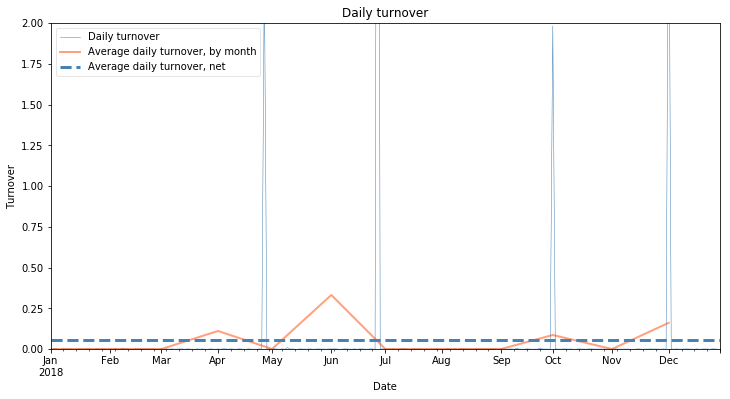

In [44]:
# Plot turnover.
pf.plot_turnover(returns, transactions, positions)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/daily_turnover.png")
plt.show()

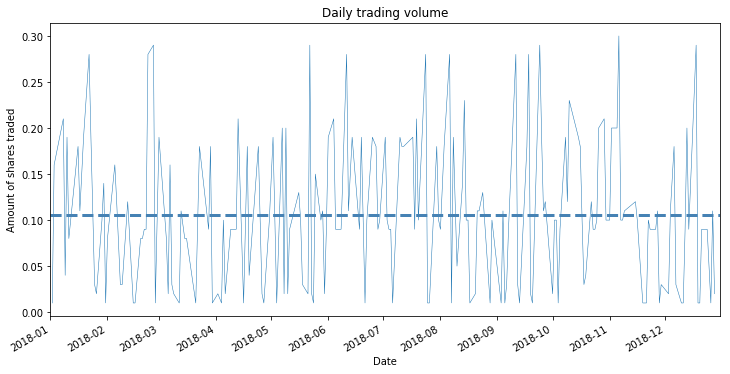

In [45]:
# Plot daily volume.
pf.plot_daily_volume(returns, transactions)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/daily_trading_volume.png")
plt.show()

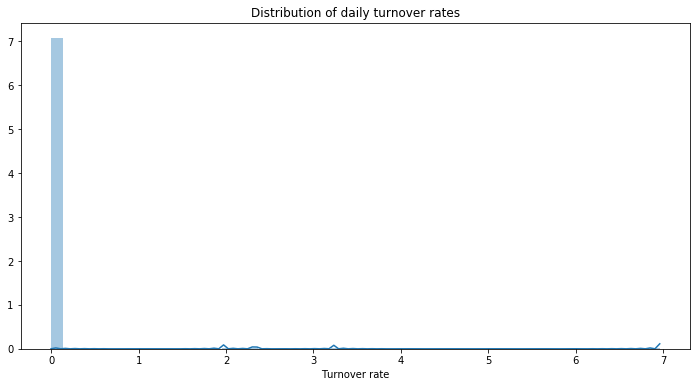

In [46]:
# Plot daily turnover hist.
pf.plot_daily_turnover_hist(transactions, positions)
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/distribution_daily_turnover_rates.png")
plt.show()

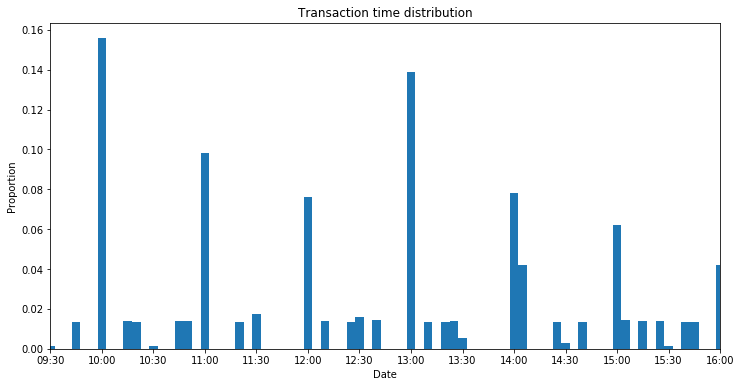

In [47]:
# Plot txn time hist.
pf.plot_txn_time_hist(transactions)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/txn_time_hist.png")
plt.show()

# 2.7 Sector Analysis.

In [48]:
# Set sector map.
sect_map = {}
for i in range(len(assets)):
    sect_map[str(i + 1)] = "Expert " + assets[i]

In [49]:
# Get positions alloc.
positions_alloc = pf.pos.get_percent_alloc(positions)

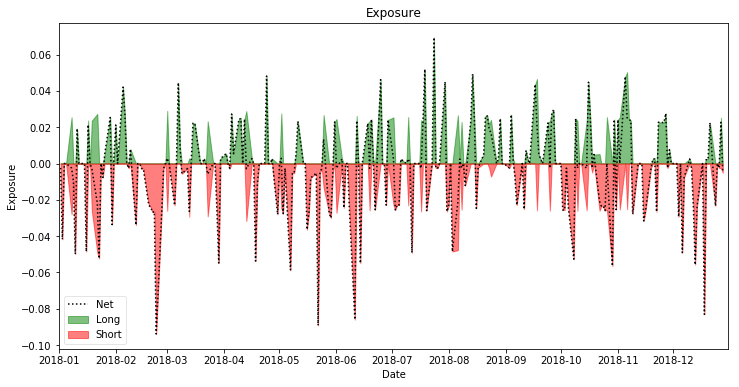

In [50]:
# Plot strategy exposures.
pf.plot_exposures(returns, positions)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/exposures.png")
plt.show()

Top 10 long positions of all time,max
2,5.03%
3,4.95%
1,0.52%


Top 10 short positions of all time,max
2,-6.04%
3,-3.36%
1,-1.21%


Top 10 positions of all time,max
2,6.04%
3,4.95%
1,1.21%


All positions ever held,max
2,6.04%
3,4.95%
1,1.21%


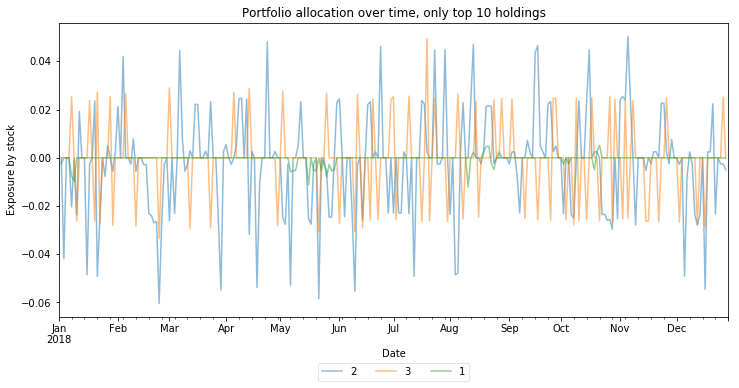

In [51]:
# Plot top positions. (We have to save the dataframe manually).
pf.show_and_plot_top_positions(returns, positions_alloc)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/show_and_plot_top_positions_2.png")
plt.show()

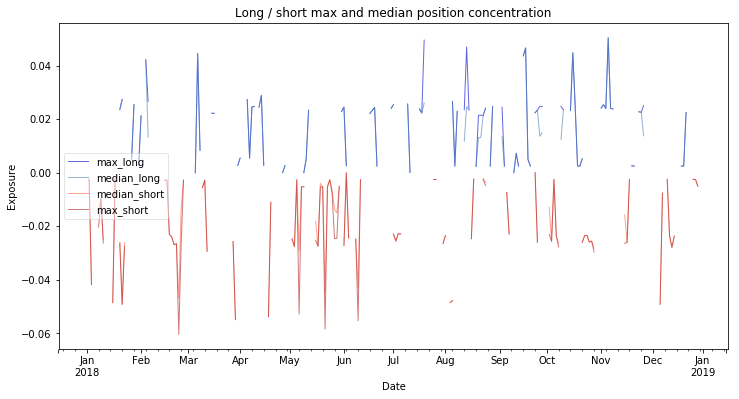

In [52]:
# Plot max median position concentration.
alloc_summary = pf.pos.get_max_median_position_concentration(positions)
colors = ['mediumblue', 'steelblue', 'tomato', 'firebrick']
alloc_summary.plot(figsize=(12,6), linewidth=1, color=colors, alpha=0.6)
plt.legend(loc = "center left", frameon = True, framealpha = 0.5)
plt.ylabel("Exposure")
plt.title("Long / short max and median position concentration")
plt.xlabel("Date")
plt.savefig("./figures/long_short_max_and_median_position_contration.png")
plt.show()

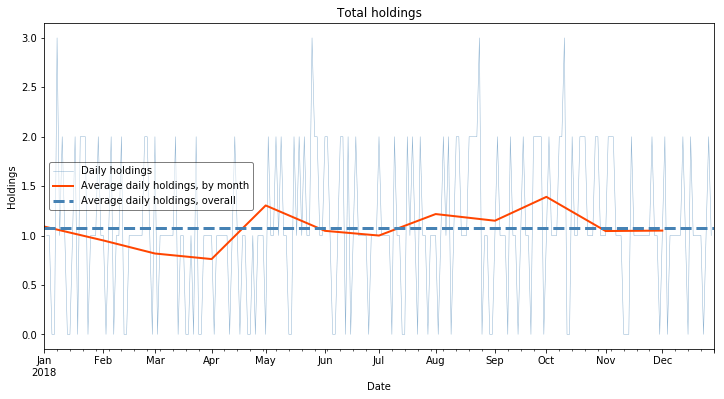

In [53]:
# Plot total holdings.
pf.plot_holdings(returns, positions_alloc)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/total_holdings.png")
plt.show()

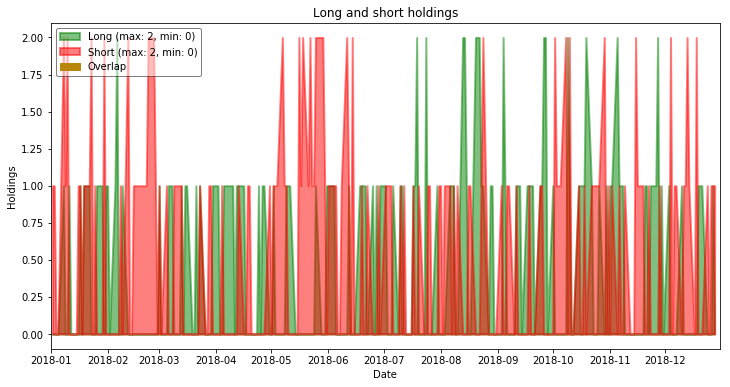

In [54]:
# Plot long-short holdings.
pf.plot_long_short_holdings(returns, positions_alloc)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/long_and_short_holdings.png")
plt.show()

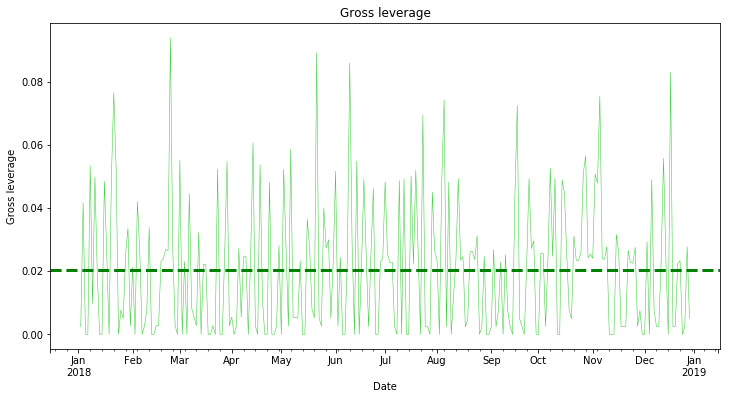

In [55]:
# Plot gross leverage.
pf.plot_gross_leverage(returns, positions)
plt.xlabel("Date")
plt.gcf().set_size_inches(12, 6)
plt.savefig("./figures/gross_leverage.png")
plt.show()

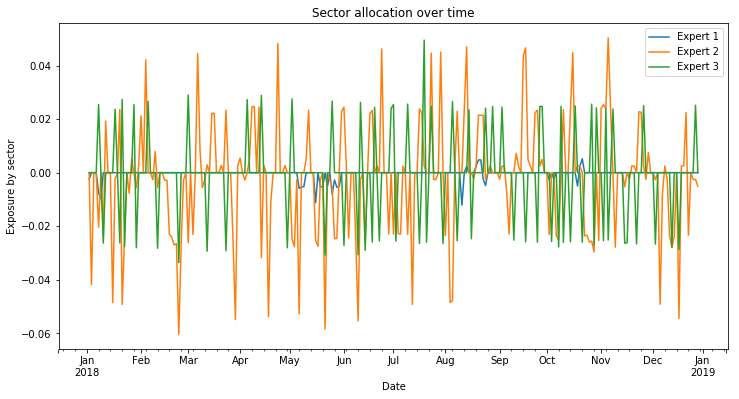

In [56]:
# Plot sector allocations.
sector_exposures = pf.pos.get_sector_exposures(positions, sect_map)
if len(sector_exposures.columns) > 1:
    sector_alloc = pf.pos.get_percent_alloc(sector_exposures)
    sector_alloc = sector_alloc.drop("cash", axis = "columns")
    sector_alloc.plot(figsize=(12,6))
    plt.title("Sector allocation over time")
    plt.ylabel("Exposure by sector")
    plt.xlabel("Date")
    plt.savefig("./figures/sector_allocation_over_time.png")
    plt.show()

# 2.8. Round trip analysis.

In [197]:
#pf.create_round_trip_tear_sheet(returns, positions, transactions, sector_mappings=sect_map)
#rts = pf.round_trips.extract_round_trips(transactions, portfolio_value=positions.sum(axis='columns') / (returns + 1))
#pf.round_trips.print_round_trip_stats(rts)

# 2.9. Bayesian Analysis.

In [198]:
#pf.create_bayesian_tear_sheet(returns, live_start_date=live_start_date)

# 2.10. Slippage Analysis.

In [53]:
# Set variables
unadjusted_returns = returns.copy()
returns_slippage = pf.txn.adjust_returns_for_slippage(returns, positions, transactions, 10)
returns_slippage.fillna(0, inplace = True)
positions_slippage = pf.utils.check_intraday(True, returns_slippage, positions, transactions)

In [20]:
# Get returns tear sheet.
#pf.create_returns_tear_sheet(returns, benchmark_rets = benchmark_rets, positions=positions, transactions=transactions, live_start_date=live_start_date)

In [21]:
# Generate interesting times.

"""
    Generate a number of returns plots around interesting points in time,
    like the flash crash and 9/11.
    Plots: returns around the dotcom bubble burst, Lehmann Brothers' failure,
    9/11, US downgrade and EU debt crisis, Fukushima meltdown, US housing
    bubble burst, EZB IR, Great Recession (August 2007, March and September
    of 2008, Q1 & Q2 2009), flash crash, April and October 2014.
    benchmark_rets must be passed, as it is meaningless to analyze performance
    during interesting times without some benchmark to refer to.
    Link: https://quantopian.github.io/pyfolio/notebooks/slippage_example/
"""

#pf.create_interesting_times_tear_sheet(returns_slippage, benchmark_rets = benchmark_rets, legend_loc="best", return_fig = False)

"\n    Generate a number of returns plots around interesting points in time,\n    like the flash crash and 9/11.\n    Plots: returns around the dotcom bubble burst, Lehmann Brothers' failure,\n    9/11, US downgrade and EU debt crisis, Fukushima meltdown, US housing\n    bubble burst, EZB IR, Great Recession (August 2007, March and September\n    of 2008, Q1 & Q2 2009), flash crash, April and October 2014.\n    benchmark_rets must be passed, as it is meaningless to analyze performance\n    during interesting times without some benchmark to refer to.\n    Link: https://quantopian.github.io/pyfolio/notebooks/slippage_example/\n"

In [22]:
#pf.create_position_tear_sheet(returns_slippage, positions_slippage)

In [23]:
# Get txn tear sheet.
#pf.create_txn_tear_sheet(returns_slippage, positions_slippage, trans, unadjusted_returns = unadjusted_returns)

# 3. Strategy Report generator.

In [229]:
# Generate template vars.
template_vars = {}
template_vars["title"] = "Investment Fund Report"

In [230]:
# Add images to template vars.
from os import listdir
from os.path import isfile, join
mypath = "./figures"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for src in onlyfiles:
    key = src.replace(".png", "_img")
    template_vars[key] = "../" + mypath + "/" + src

In [231]:
# Returns correlation.
template_vars["returns_correlation"] = corrs.to_html()

# Montecarlo info. 
template_vars["positive_outcomes_abs"] = positive_outcomes_abs
template_vars["negative_outcomes_abs"] = negative_outcomes_abs 
template_vars["positive_outcomes_rel"] = positive_outcomes_rel
template_vars["negative_outcomes_rel"] = negative_outcomes_rel
template_vars["montecarlo_initial_balance"] = last_balance
template_vars["montecarlo_days_simulated"] = montecarlo_days_simulated 
template_vars["montecarlo_mean_balance"] = montecarlo_mean_balance
template_vars["montecarlo_mean_netprofit"] = montecarlo_mean_netprofit
template_vars["montecarlo_profiability"] = montecarlo_profiability

# Efficient Frontier.
template_vars["allocation_results"] = opt_results.x
template_vars["optimal_sharpe_ratio"] = optimal_sharpe_ratio
template_vars["robot_names"] = robot_names
template_vars["stop_loss_pips"] = stop_loss_pips

In [232]:
template_vars

{'allocation_results': array([0.987, 0.013, 0.   ]),
 'annual_returns_img': '.././figures/annual_returns.png',
 'asset_price_img': '.././figures/asset_price.png',
 'balance_img': '.././figures/balance.png',
 'cash_img': '.././figures/cash.png',
 'cumulative_returns_benchmark_img': '.././figures/cumulative_returns_benchmark.png',
 'cumulative_returns_img': '.././figures/cumulative_returns.png',
 'cumulative_returns_log_scale_img': '.././figures/cumulative_returns_log_scale.png',
 'daily_trading_volume_img': '.././figures/daily_trading_volume.png',
 'daily_turnover_img': '.././figures/daily_turnover.png',
 'distribution_daily_turnover_rates_img': '.././figures/distribution_daily_turnover_rates.png',
 'distribution_monthly_returns_img': '.././figures/distribution_monthly_returns.png',
 'efficient_frontier_img': '.././figures/efficient_frontier.png',
 'entries_month_img': '.././figures/entries_month.png',
 'entries_week_days_img': '.././figures/entries_week_days.png',
 'entries_year_img': 

In [240]:
# Generate HTML strategy report.
from jinja2 import Environment, FileSystemLoader
env = Environment(loader = FileSystemLoader("."))
template = env.get_template("./portfolio_report_template.html")

html_out = template.render(template_vars)
html_out

Html_file = open("./reports/portfolio_report.html", "w")
Html_file.write(html_out)
Html_file.close()

In [241]:
# Import pdfkit.
import pdfkit
config = pdfkit.configuration(wkhtmltopdf = bytes("C:/Users/Juan Esteban/Desktop/wkhtmltopdf/bin/wkhtmltopdf.exe", "utf-8"))

In [242]:
# Set files path.
html_path = "./reports/portfolio_report.html"
pdf_path = "./reports/portfolio_report.pdf"

In [243]:
# Generate PDF report.
pdfkit.from_file(html_path, pdf_path, configuration = config)

Loading pages (1/6)
QWin32PrintEngine::initialize: OpenPrinter failed (No printers were found.)
QWin32PrintEngine::initialize: OpenPrinter failed (No printers were found.)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                        


True

# 4. Send email.

In [249]:
# Import libraries.
import smtplib, ssl
import email

In [250]:
# Set email variables.
port = 465
password = """TR{-2C"6:UxB&Jef"""
sender_email = "tradinginformant@gmail.com"

receiver_email = "junes9710@gmail.com"
#receiver_email = "josealilopez1970@gmail.com"
receiver_list = ["sebastianzapataveira@hotmail.com", "junes9710@gmail.com", "miamorenovi@unal.edu.co", "lrodriguez22000@gmail.com", "santiago.alvarez.sepulveda@gmail.com"]
#receiver_list = ["lrodriguez22000@gmail.com", "junes9710@gmail.com", "juandgomezri@gmail.com"]

In [251]:
# Generate message.
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
from email.mime.base import MIMEBase
from email import encoders

msg = MIMEMultipart()
msg["From"] = sender_email
msg["To"] = receiver_email
msg["Subject"] = "Investment Fund Report"

text = MIMEText("Report generated by Python.")
msg.attach(text)

pdf_report = open(pdf_path, "rb").read()
attached_pdf = MIMEApplication(pdf_report, _subtype = "pdf", _encoder = encoders.encode_base64)
attached_pdf.add_header("content-disposition", "attachment", filename = "Investment Fund Report")
msg.attach(attached_pdf)

In [252]:
send_all = (input("Remitir el reporte a todos los correos? y/n  ==> ") == "y")

Remitir el reporte a todos los correos? y/n  ==> y


In [253]:
if send_all:
    receivers = receiver_list
else:
    receivers = receiver_email

In [254]:
# Set context.
context = ssl.create_default_context()
 
# Send email.
with smtplib.SMTP_SSL("smtp.gmail.com", port, context = context) as server:
    try:
        server.login(sender_email, password)
        server.sendmail(sender_email, receivers, msg.as_string())
        print("Email sent to ", receivers)
        server.quit()
    except:
        print("Unknown Error")

Email sent to  ['sebastianzapataveira@hotmail.com', 'junes9710@gmail.com', 'miamorenovi@unal.edu.co', 'lrodriguez22000@gmail.com', 'santiago.alvarez.sepulveda@gmail.com']
